In [1]:
using Distributions
using Random
using Plots
using PyPlot
using StatsBase
using StatsPlots

# Updates

We have introduced Unif-BAS and Cont-BAS for training with the Binary Action Space (BAS). Retroactively, we shall now call the restricted action space the Linear Action Space, or LAS. Alongside this, we have introduced gEval-BAS, which evaluates the VFA using just the BAS actions, whereas gEval would essentially perform PI using the LAS.

We also investigate the use of single indicator functions for the inhomogeneous problem, omitting the expensive and often small cross-terms. Results show that they are not missed.

We also add a new version of AVI-Cont, in which a value g0 is provided for action selection. This was motivated by some inital not-so-good results for an N = 10 inhomogeneous problem. However, fixing g0 = 0 in the AVI, we got a much better policy.

# AVI-Suite

AVI-Suite provides the necessary functions for uniformised AVI, continuous time AVI, evaluation via simulation, and exact evaluation via DP, all in one place. This provides a flexible testbed for testing all four of the AVI algorithms, and ensures that all functions are named such that their purpose is clear, and there is no confusion between similar functions.

Sections:

-[Miscellaneous Functions](#Miscellaneous-Functions)

-[Pre-requisite functions for uniformised AVI](#Pre-requisite-functions-for-uniformised-AVI)

-[Uniformised AVI functions](#Uniformised-AVI-functions)

-[Pre-requisite functions for continuous time AVI](#Pre-requisite-functions-for-continuous-time-AVI)

-[SMARVI Functions](#SMARVI-Functions)

-[Pre-requisite Functions for Exact DP on Homogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Homogeneous-Problems)

-[Exact DP on Homogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Homogeneous-problem)

-[Pre-requisite Functions for Exact DP on Inhomogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Inhomogeneous-Problems)

-[Exact DP on Inhomogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Inhomogeneous-Problem-(using-exact-h-or-VFA))

-[Evaluation via simulation](#Evaluation-via-simulation)

-[APE on Fully Active Policy](#APE-on-Fully-Active-Policy)

-[APE using a given VFA](#APE-using-a-given-VFA)

-[New Functions](#New-Functions)

-[Tests](#Tests)

# Miscellaneous Functions

-Functions for enumerating state and action spaces

-Functions for calculating flows given a state or state-action pair

-Function for evaluating a VFA at a given state

In [2]:
#produce an array of array representations of all possible states
function enumerateStates(N::Int64)
    if N==1
        return [[1],[2],[3]]
    end
    
    output = []
    lower = enumerateStates(N-1)
    for s in lower
        new1 = append!([1],s)
        new2 = append!([2],s)
        new3 = append!([3],s)
        append!(output,[new1])
        append!(output,[new2])
        append!(output,[new3])
    end
    
    return output
end

#produce an array of array representations of all possible actions
function enumerateActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = []
    lower = enumerateActions(N-1)
    for a in lower
        new1 = append!([0],a)
        new2 = append!([1],a)
        append!(output,[new1])
        append!(output,[new2])
    end
    
    return output
end    

#produce array of array representations of all restricted, or single-repair, actions
function enumerateRestrictedActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = [zeros(Int64,N)]
    for i in 1:N
        temp = zeros(N)
        temp[i] = 1
        append!(output,[temp])
    end
    
    return output
end

#convert all array elements to string, then concatanate all elements (DEPRECATED AS DICTS CAN TAKE ARRAYS AS KEYS)
function arrayToString(x)
    return join(string.(x))
end

arrayToString (generic function with 1 method)

In [3]:
#function for calculating the flows given a state
function calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    #update flows
    flows = zeros(N)
    healthy = sum(i == 1 for i in s)
    
    #if no links are healthy, return 
    if healthy == 0
        return flows, c1
    end
    
    #otherwise, find best route, and return
    bestCost = maximum(c0) + 1
    usedLink = 0
    for k in 1:N
        if s[k] == 1 && c0[k] < bestCost
            bestCost = c0[k]
            usedLink = k
        end
    end
    
    flows[usedLink] = beta
    
    return flows, bestCost
end

#function for calculating the flows given a state-action pair
function calculateFlows(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    sPrime = s - a
    return calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
end

calculateFlows (generic function with 2 methods)

In [4]:
#evaluate a VFA at a given state
function v(s, params, features)
    numFeatures = length(features)
    return params[1] + sum(params[i+1]*features[i](s) for i in 1:numFeatures)
end

v (generic function with 1 method)

# Pre-requisite functions for uniformised AVI

In [5]:
#Given a state-action pair, return the next random pre-decision state, the instant cost, and the updated flows
function updateStateAndFlowsUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #observe exogenous information
    w = rand(Uniform(0, 1))
    
    #interpret exog info: is it a demand deg, rare deg, or completed repair 
    found = false
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        if runningTotal <= w <= runningTotal + flows[k]*alpha_d[k]*del
            found = true
            sPrime[k] = 3
            #println("Demand Deg at "*string.(k))
            break
        end
        runningTotal = runningTotal + flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    if found == false
        for k in 1:N
            if runningTotal <= w <= runningTotal + alpha_r[k]*del
                found = true
                sPrime[k] = 3
                #println("Rare Deg at "*string.(k))
                break
            end
            runningTotal = runningTotal + alpha_r[k]*del
        end
    end
    
    #repairs
    if found == false && repair > 0
        if runningTotal <= w <= runningTotal + tau(repair)*del
            found = true
            #find all repairing links
            repairing = []
            for k in 1:N
                if sPrime[k] == 2
                    append!(repairing,[k])
                end
            end
            repaired = sample(repairing)
            sPrime[repaired] = 1
            #println("Repair completed at "*string.(repaired))
        end
    end
    
    if found == false
        #println("No Event")
    end
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    healthy = sum(i == 1 for i in sPrime)
    
    return sPrime, (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del, newFlows
end

updateStateAndFlowsUnif (generic function with 1 method)

In [6]:
#instant cost over the timestep
function instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    sPrime = s - a
    healthy = sum(sPrime[i] == 1 for i in 1:N)
    repair = sum(sPrime[i] == 2 for i in 1:N)
    damaged = sum(sPrime[i] == 3 for i in 1:N)
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    
    return (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del
end

instantCostUnif (generic function with 1 method)

In [7]:
#Calculates E(h(s')) given a state-action pair, and a VFA for h. Also used in Exact PE/PI when using a VFA
#One version takes flows as an argument, the other calculates the flows
function expectedNextValueUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    runningTotal = 0.0
    runningTotalProb = 0.0
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*v(sPrime, vParams, features)
end  

function expectedNextValueUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, vParams, features)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    flows = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    runningTotal = 0.0
    runningTotalProb = 0.0
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*v(sPrime, vParams, features)
end  

expectedNextValueUnif (generic function with 2 methods)

# Uniformised AVI functions

In [8]:
#Performs AVI in uniformised setting, approximating E(h(s')) for update targets using just h(s'), where s' is the next simulated state
function aviApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        optV = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - g
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
            
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + v(sPrime, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

aviApprox (generic function with 1 method)

In [9]:
#Performs AVI in uniformised setting, approximating E(h(s')) using all possible transitions
function aviFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        optV = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - g
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
            
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

aviFull (generic function with 1 method)

In [10]:
#Performs AVI with BAS in uniformised setting, approximating E(h(s')) using all possible transitions
function aviUnifBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        vs0 = v(s0, vParams, features)
        #formulate optimal action
        optA = zeros(Int64,N)
        optV = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - vs0
        
        testA = faAction(s)
        testV = instantCostUnif(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - vs0
        if testV <= optV
            optV = testV
            optA = testA
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optA = testA
            optV = testV
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

aviUnifBAS (generic function with 1 method)

# Pre-requisite functions for continuous time AVI

In [11]:
#Calculate the expected sojourn time of a state-action pair
function sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    s = s - a
    if s == fill(3,N)
        return 1/(beta*sum(alpha_d) + sum(alpha_r) + tau(N))
    end
    
    numRep = sum(i == 2 for i in s)
    cumulativeRate = 0.0
    for i in 1:N
        if s[i] == 1
            cumulativeRate += flows[i]*alpha_d[i] + alpha_r[i]
        elseif s[i] == 2
            cumulativeRate += alpha_r[i] + tau(numRep)/numRep
        end
    end
    
    return 1/cumulativeRate
end

sojournTime (generic function with 1 method)

In [12]:
#calculate the expected cost accumulated until a transition 
function instantCostCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = 0)
    if del == 0
        del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    end
    
    return instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
end

instantCostCont (generic function with 1 method)

In [13]:
#Given a state-action pair, return the next random pre-decision state, the cost accumulated over the sojourn time, and the updated flows
function updateStateAndFlowsCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    actualTime = rand(Exponential(del))
    result = updateStateAndFlowsUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
    return result[1], instantCostCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = actualTime), result[3], actualTime
end

updateStateAndFlowsCont (generic function with 1 method)

In [14]:
#Calculates E(h(s')) given a state-action pair, and a VFA for h
function expectedNextValueCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return v(sPrime,vParams,features)
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
            end
        end
    end
    
    return runningTotal
end   

expectedNextValueCont (generic function with 1 method)

# SMARVI Functions

In [15]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions
function smarvi(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                if vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures) <= optV
                    optV = vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures)
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = v(s-a, vParams, features)
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            bestV = optV - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarvi (generic function with 1 method)

In [16]:
#Performs AVI in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
function smarviST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    stateTrace = []
    actionFlag = false
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        #update stateTrace
        append!(stateTrace, [s])
        
        #formulate optimal action and calculate optV
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                testV = v(s-a, vParams, features)
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
        
        #If wanted, force a repair if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA = zeros(Int64,N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = v(s-a, vParams, features)
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #if optimal action is passive, update VFA for all states in the stateTrace, and simulate the next state
        if bestA == zeros(Int64, N)
            
            #find simulated next state
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
        
            bestV = optV - v(s0, vParams, features)
            
            #update VFA
            traceLength = length(stateTrace)
            for sTrace in stateTrace
                currentEst = v(sTrace, vParams, features)
                grad = append!([1.0],[features[i](sTrace) for i in 1:numFeatures])
                vParams = vParams + (stepsize)*(bestV - currentEst)*grad
                append!(paramHist,[vParams])
            end
            
            #reset stateTrace
            stateTrace = []
            
            #update flows and average
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
            
        #if some action is optimal, simply update the state
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarviST (generic function with 1 method)

In [17]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions, and controlling action selection using some fixed g0
function smarvi_g0(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features, g0; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g0*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                if vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures) <= optV
                    optV = vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures)
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = v(s-a, vParams, features)
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            bestV = optV + g0*t - g*t - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarvi_g0 (generic function with 1 method)

In [18]:
#Performs AVI with BAS in the continuous time setting, approximating E(h(s')) using all possible transitions
function smarviBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        tPassive = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*tPassive
        
        testA = faAction(s)
        tActive = sojournTime(s, testA, flows, N, alpha_d, alpha_r, beta, tau)
        testV = instantCostCont(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*tActive
        
        if testV <= optV
            optV = testV
            optA = testA
        end
        
        #Ignore passive action for broken network
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optV = testV
            optA = testA
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - v(s0, vParams,features)
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarviBAS (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Homogeneous Problems 

In [19]:
#instant cost function strictly for homogeneous problem
function instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    
    #if no links are healthy, return 
    if N - i1 - i2 == 0
        return (beta*c1 + r*i2Prime)*del
    end
    
    
    return (beta*c0 + r*i2Prime)*del
end

instantCostHomog (generic function with 1 method)

In [20]:
#calculates E(h(s')) from s,a strictly for a homogeneous problem
function expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    thisH = h[i1+1,i2+1]
    
    #if all are damaged
    if i1Prime == N
        return thisH
    end
    
    #if none are healthy
    if N - i1 - i2 == 0
        return thisH + tau(i2Prime)*del*(h[i1Prime+1,i2Prime-1+1] - thisH) + i2Prime*del*alpha_r*(h[i1Prime+1+1, i2Prime-1+1] - thisH)
    end
    
    #if none are repairing
    if i2Prime == 0
        return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH)
    end
    
    return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH) + i2Prime*alpha_r*del*(h[i1Prime+1+1,i2Prime-1+1] - thisH) + tau(i2Prime)*del*(h[i1Prime+1,i2Prime-1+1] - thisH)
end

expectedNextValueHomog (generic function with 1 method)

In [21]:
#calculates the exact PI action strictly for a homogeneous problem
function piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    if i1 == 0
        return 0
    end
    
    if i1 == N && forceActive
        optA = 1
        optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        for a in 2:i1
            testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    for a in 1:i1
        testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomog (generic function with 1 method)

In [22]:
#calculates the approx PI action based on instantaneous approximation, strictly for a homogeneous problem
function piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    if i1 == 0
        return 0
    end
    
    if i1 == N && forceActive
        optA = 1
        optH = h[i1-optA+1,i2+optA+1]
        for a in 2:i1
            testH = h[i1-a+1,i2+a+1]
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) - g*del
    for a in 1:i1
        testH = h[i1-a+1,i2+a+1]
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomogApprox (generic function with 1 method)

In [23]:
#calculates the exact PI policy strictly for a homogeneous problem
function piPolicyHomog(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomog (generic function with 1 method)

In [24]:
#calculates the approx PI policy based on instantaneous approximation, strictly for a homogeneous problem
function piPolicyHomogApprox(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomogApprox (generic function with 1 method)

In [25]:
function hFromVFAHomog(N, params, features)
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    return hIn
end

hFromVFAHomog (generic function with 1 method)

# Exact DP for Homogeneous problem

In [26]:
#Evaluates a PI policy based on a given exact h function, strictly for a homogeneous problem 
function rpiHomog(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomog(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomog (generic function with 1 method)

In [27]:
#Evaluates the fully active policy, strictly for a homogeneous problem 
function rpeFAHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = i1
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n
end

rpeFAHomog (generic function with 1 method)

In [28]:
#Evaluates an approximate PI policy based on a given exact h function and instananeous actions, strictly for a homogeneous problem 
function rpiHomogApprox(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64, g::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomogApprox(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomogApprox (generic function with 1 method)

In [29]:
#Evaluates a PI policy based on a given VFA, using instananeous approximation, strictly for a homogeneous problem 
function rpiHomogVFAApprox(N::Int64, params, features, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64, g::Float64; nMax = 0, delScale = 1, forceActive = false)
    
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    #run standard function
    return rpiHomogApprox(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = nMax, delScale = delScale, forceActive = forceActive)
end

rpiHomogVFAApprox (generic function with 1 method)

In [30]:
#Evaluates a PI policy based on a given VFA, strictly for a homogeneous problem 
function rpiHomogVFA(N::Int64, params, features, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    #run standard function
    return rpiHomog(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, forceActive = forceActive)
end

rpiHomogVFA (generic function with 1 method)

In [31]:
#Evaluates a PI policy based on a given exact h function, strictly for a homogeneous problem 
function rviHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n
end

rviHomog (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Inhomogeneous Problems

In [32]:
#calculates E(h(s')) from s,a using exact h table
function expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    runningTotal = 0.0
    runningTotalProb = 0.0
    
    flows = zeros(Float64, N)
    if healthy > 0
        #otherwise, find best route, and return
        bestCost = maximum(c0) + 1
        usedLink = 0
        for k in 1:N
            if sPrime[k] == 1 && c0[k] < bestCost
                bestCost = c0[k]
                usedLink = k
            end 
        end
        
        flows[usedLink] = beta
    end
    
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*h[sNext]
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*h[sNext]
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*h[sNext]
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*h[sPrime]
end 

expectedNextValueExact (generic function with 1 method)

In [33]:
#calculates PI action using exact h table
function piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionExact (generic function with 1 method)

In [34]:
#calculates PI action using exact h table, based off instananeous actions
function piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h) - g*del
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = h[s-a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionExactInstant (generic function with 1 method)

In [35]:
#calculates PI action using a VFA
function piActionVFA(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features)
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionVFA (generic function with 1 method)

In [36]:
#calculates PI action using a VFA and instananeous actions
function piActionVFAInstant(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features) - g*del
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = v(s-a,params,features)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionVFAInstant (generic function with 1 method)

In [37]:
#calculates PI policy using exact h table
function piPolicyExact(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    end
    
    return policy
end

piPolicyExact (generic function with 1 method)

In [38]:
#calculates PI policy using exact h table, interpretting h with instant actions
function piPolicyExactInstant(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    end
    
    return policy
end

piPolicyExactInstant (generic function with 1 method)

In [39]:
#calculates PI policy from a VFA
function piPolicyVFA(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionVFA(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    end
    
    return policy
end

piPolicyVFA (generic function with 1 method)

In [40]:
#calculates PI policy from a VFA, using instant actions to interpret h
function piPolicyVFAInstant(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionVFAInstant(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    end
    
    return policy
end

piPolicyVFAInstant (generic function with 1 method)

# Exact DP for Inhomogeneous Problem (using exact h or VFA)

In [41]:
#Performs PE using exact policy table
function rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpe (generic function with 1 method)

In [42]:
#Performs one round of exact PI and PE using exact h table
function rpiExact(N, h, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    policy = piPolicyExact(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n, policy
end

rpiExact (generic function with 1 method)

In [43]:
#Performs one round of exact PI and PE using exact h table, using instant actions to interpet h
function rpiExactInstant(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    policy = piPolicyExactInstant(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpiExactInstant (generic function with 1 method)

In [44]:
#Performs exact PE on the fully-active policy
function rpeFA(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct fully active action
            a = zeros(Int64, N)
            for i in 1:N
                if s[i] == 3
                    a[i] = 1
                end
            end 
            
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpeFA (generic function with 1 method)

In [45]:
#Performs exact PE on the passive policy
function rpePassive(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct fully active action
            a = zeros(Int64, N) 
            
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpePassive (generic function with 1 method)

In [46]:
#Performs one round of exact PI and PE using VFA
function rpiVFA(N, params, features, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    policy = piPolicyVFA(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct action
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpiVFA (generic function with 1 method)

In [47]:
#Performs one round of exact PI and PE using VFA and instantaneous actions to interpret h
function rpiVFAInstant(N, params, features, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    policy = piPolicyVFAInstant(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct action
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpiVFAInstant (generic function with 1 method)

In [48]:
#Performs RVIA
function rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    policy = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
        policy[s] = zeros(Int64,N)
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n, policy
end

rvi (generic function with 1 method)

# Evaluation via simulation

In [49]:
#Evaluates a VFA via PI using simulation
function gEvaluation(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluation (generic function with 1 method)

In [50]:
#Evaluates a VFA using simulation
function gEvaluationFromS(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    flowResult = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    flows = flowResult[1]
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end 
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationFromS (generic function with 1 method)

In [51]:
#Evaluates a VFA using simulation
function gEvaluation_g0(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features, g0; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g0*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluation_g0 (generic function with 1 method)

In [52]:
#Evaluates a VFA using simulation
function gEvaluationFromS_g0(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features, g0; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    flowResult = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    flows = flowResult[1]
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end 
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g0*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationFromS_g0 (generic function with 1 method)

In [53]:
#Evaluates a VFA using simulation
function gEvaluationFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        bestA = faAction(s)
        
        #update state and flows
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationFA (generic function with 1 method)

In [54]:
#Evaluates a VFA via PI using simulation
function gEvaluationBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        tPassive = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*tPassive
        
        testA = faAction(s)
        tActive = sojournTime(s, testA, flows, N, alpha_d, alpha_r, beta, tau)
        testV = instantCostCont(s,testA, N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*tActive
        if testV <= optV
            optV = testV
            optA = testA
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA = testA
            optV = testV
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationBAS (generic function with 1 method)

# APE on Fully Active Policy

Performs APE on the Fully Active Policy using each of the four approaches to estimating a VFA (mixes of uniform/continuous and simulated-next-state/expectation)

In [55]:
#Computes the Fully Active action for a given state s
function faAction(s)
    N = length(s)
    a = zeros(Int64,N)
    for i in 1:N
        if s[i] == 3
            a[i] = 1
        end
    end
    return a
end

faAction (generic function with 1 method)

In [56]:
#Performs APE of FA policy in uniformised setting, approximating E(h(s')) for update targets using just h(s'), where s' is the next simulated state
function apeFAUnifApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + v(sPrime, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAUnifApprox (generic function with 1 method)

In [57]:
#Performs APE of FA policy in uniformised setting, approximating E(h(s')) using all possible transitions
function apeFAUnifFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + expectedNextValueUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAUnifFull (generic function with 1 method)

In [58]:
#Performs APE on FA policy in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
function apeFAContApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + v(sPrime, vParams, features) - g*t - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContApprox (generic function with 1 method)

In [59]:
function apeFAContFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + expectedNextValueCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContFull (generic function with 1 method)

In [60]:
#Performs APE on FA policy in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
#Also incorporates the state trace when actions are taken
function apeFAContApproxST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    stateTrace = []
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        #update state trace
        append!(stateTrace, [s])
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #for passive action, do proper update
        if bestA == zeros(Int64,N)
            #find value of v^n
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + v(sPrime, vParams, features) - g*t - v(s0, vParams,features)

            #update VFA
            for sTrace in stateTrace
                currentEst = v(sTrace, vParams, features)
                grad = append!([1.0],[features[i](sTrace) for i in 1:numFeatures])
                vParams = vParams + (stepsize)*(bestV - currentEst)*grad
                append!(paramHist,[vParams])
            end
            
            stateTrace = []
            
            #update g, state, and flows
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]

            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
            
        #for other action, simply update state and move on
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContApproxST (generic function with 1 method)

In [61]:
#Performs APE on FA policy in continuous time setting, approximating E(h(s')) using all possible transitions
#Also incorporates the state trace when actions are taken
function apeFAContFullST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    stateTrace = []
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        #update state trace
        append!(stateTrace, [s])
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #for passive action, do proper update
        if bestA == zeros(Int64,N)
            #find value of v^n
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + expectedNextValueCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t - v(s0, vParams,features)

            #update VFA
            for sTrace in stateTrace
                currentEst = v(sTrace, vParams, features)
                grad = append!([1.0],[features[i](sTrace) for i in 1:numFeatures])
                vParams = vParams + (stepsize)*(bestV - currentEst)*grad
                append!(paramHist,[vParams])
            end
            
            stateTrace = []
            
            #update g, state, and flows
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]

            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
            
        #for other action, simply update state and move on
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContFullST (generic function with 1 method)

# SMARPE

## Semi-Markov Approximate Relative Policy Evaluation

- SMARPE takes some trained VFA as input, and seeks to learn the associated long run cost g and the value function of the policy derived from the given VFA

- Standard SMARPE uses the online training value of g for action selection, allowing the policy to vary throughout training

- SMARPE_g0 takes a pre-learned value of g0 to be used for action selection, keeping the policy constant throughout. This value of g0 might be taken directly from SMARVI or from some gEval function.

Worth also discussing is the exact behaviour of the gEval functions.

- Standard gEval simply evaluates a VFA, and learns g throughout. In turn, this value of g is used for action selection, so the policy may vary throughout evaluation.

- gEval_g0 evaluates a VFA-g0 pair, keeping the policy constant throughout. It may be good practice to always follow standard gEval with gEval_g0, due to the lack of policy variability.

gEval functions are the part that actually calculate the PI actions based on the VFAs derived from SMARPE.

In [62]:
#Performs APE in the continuous time setting, approximating E(h(s')) using all possible transitions
function smarpe(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, paramsIn, paramsOut, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [paramsOut]
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, paramsIn, features) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                testV = v(s-a, paramsIn, features)
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
        
        #Avoid passive action for state [3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, paramsIn, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = v(s-a, paramsIn, features)
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #recalculate optA in terms of new VFA
        if bestA == zeros(Int64, N)
            optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, paramsOut, features) - g*t
        else
            optV = v(s - bestA, paramsOut, features)
        end 
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - v(s0, paramsOut ,features)
        
        #update VFA
        currentEst = v(s, paramsOut, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        paramsOut = paramsOut + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[paramsOut])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs, [g])
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return paramsOut, paramHist, g, gs
end

smarpe (generic function with 1 method)

In [63]:
#Performs APE in the continuous time setting, approximating E(h(s')) using all possible transitions, and with a fixed g0 for action selection
function smarpe_g0(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, paramsIn, paramsOut, features, g0; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [paramsOut]
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, paramsIn, features) - g0*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                testV = v(s-a, paramsIn, features)
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
        
        #Avoid passive action for state [3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, paramsIn, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = v(s-a, paramsIn, features)
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #recalculate optA in terms of new VFA
        if bestA == zeros(Int64, N)
            optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, paramsOut, features) - g*t
        else
            optV = v(s - bestA, paramsOut, features)
        end 
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - v(s0, paramsOut ,features)
        
        #update VFA
        currentEst = v(s, paramsOut, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        paramsOut = paramsOut + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[paramsOut])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs, [g])
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return paramsOut, paramHist, g, gs
end

smarpe_g0 (generic function with 1 method)

# New Functions

In [64]:
function randomAction(s,N)
    damaged = [0]
    for i in 1:N
        if s[i] == 3
            append!(damaged, [i])
        end
    end
            
    choice = sample(damaged)
    optA = zeros(Int64, N)
    if choice == 0
        return optA
    else
        optA[choice] = 1
        return optA
    end
end

randomAction (generic function with 1 method)

In [65]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions
#actions are choosen via e-greedy action selection, where a random action is chosen with probability a/a+n
function smarvi_epsGreedy(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; b = 1.0, printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate e-greedy action
        if rand(Uniform(0,1)) <= b/(b + n) 
            optA = randomAction(s,N)
            if optA == zeros(Int64, N)
                t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
            else
                optV = v(s-optA, vParams, features)
            end
        else                
            optA = zeros(Int64,N)
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        
            for i in 1:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1

                    if vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures) <= optV
                        optV = vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures)
                        optA = a
                    end
                end
            end

            if s == fill(3,N) && optA == zeros(Int64, N)
                optA[1] = 1
                optV = v(s-optA, vParams, features)

                for i in 2:N
                    if s[i] == 3
                        a = zeros(Int64, N)
                        a[i] = 1
                        testV = v(s-a, vParams, features)
                        if testV <= optV
                            optV = testV
                            optA = a
                        end
                    end
                end
            end
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            bestV = optV - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarvi_epsGreedy (generic function with 1 method)

In [66]:
#Calculates E(h(s')) given a state-action pair, and tabular h
function expectedNextValueContTab(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return h[sPrime]
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*h[sNext]
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*h[sNext]
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*h[sNext]
            end
        end
    end
    
    return runningTotal
end   

expectedNextValueContTab (generic function with 1 method)

In [67]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions
#Uses tabular representation instead of VFA
function smarviTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]

    h = Dict()
    for s in stateSpace
        h[s] = 0.0
    end
    
    numVisits = Dict()
    for s in stateSpace
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                if h[s-a] <= optV
                    optV = h[s-a]
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = h[s-optA]
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = h[s-a]
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            bestV = optV - h[s0]
        else
            bestV = optV - h[s0]
        end 
        
        #update VFA
        currentEst = h[s]
        h[s] += (b/(b + numVisits[s]))*(bestV - currentEst)
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarviTab (generic function with 1 method)

In [68]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions
#Uses tabular representation instead of VFA
function smarviTab_epsGreedy(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]

    h = Dict()
    for s in stateSpace
        h[s] = 0.0
    end
    
    numVisits = Dict()
    for s in stateSpace
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                if h[s-a] <= optV
                    optV = h[s-a]
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = h[s-optA]
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = h[s-a]
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        if rand(Uniform(0,1)) < c/(c + numVisits[s])
            optA = randomAction(s, N)
        end 
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            bestV = optV - h[s0]
        else
            bestV = optV - h[s0]
        end 
        
        #update VFA
        currentEst = h[s]
        h[s] += (b/(b + numVisits[s]))*(bestV - currentEst)
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarviTab_epsGreedy (generic function with 1 method)

In [69]:
#calculates PI action using exact h table, based off continuous model
function piActionExactCont(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    
    optA = zeros(Int64, N)
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    optH = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows,h) - g*t
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = h[s-a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end

    if s == fill(3,N) && optA == zeros(Int64, N)
        optA[1] = 1
        optH = h[s - optA]

        for i in 2:N
            a = zeros(Int64, N)
            a[i] = 1
            testH = h[s - a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end

    return optA
end

piActionExactCont (generic function with 1 method)

In [70]:
function piPolicyExactCont(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g)
    stateSpace = enumerateStates(N)
    policy = Dict()
    for s in stateSpace
        policy[s] = piActionExactCont(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g)
    end

    return policy
end

piPolicyExactCont (generic function with 1 method)

In [71]:
function gEvaluationTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, h, g0; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    println("State Space Completed")
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    
    policy = piPolicyExactCont(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g0)
    println("Policy Completed")

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = policy[s]
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs
end

gEvaluationTab (generic function with 1 method)

In [72]:
#version of v that takes flows for the features
function v(s, flows, params, features)
    N = length(params)
    return params[1] + sum(params[i]*features[i-1](s, flows) for i in 2:N)
end

v (generic function with 2 methods)

In [73]:
#Calculates E(h(s')) given a state-action pair, and a VFA for h
function expectedNextValueContFlows(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return v(sPrime, flows, vParams,features)
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        flowsNext = calculateFlows(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, flowsNext, vParams, features)
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            flowsNext = calculateFlows(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
            runningTotal += alpha_r[k]*del*v(sNext, flowsNext, vParams, features)
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                flowsNext = calculateFlows(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
                runningTotal += (tau(repair)/repair)*del*v(sNext, flowsNext, vParams, features)
            end
        end
    end
    
    return runningTotal
end   

expectedNextValueContFlows (generic function with 1 method)

In [74]:
#version of smarvi where flows are passed to features
function smarviFlows(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    flows0 = copy(flows)
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContFlows(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                if vParams[1] + sum(vParams[i+1]*features[i](s-a, flows) for i in 1:numFeatures) <= optV
                    optV = vParams[1] + sum(vParams[i+1]*features[i](s-a, flows) for i in 1:numFeatures)
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, flows, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = v(s-a, flows, vParams, features)
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            bestV = optV - v(s0, flows0, vParams,features)
        else
            bestV = optV - v(s0, flows0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s, flows) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s, flows) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarviFlows (generic function with 1 method)

In [75]:
#Evaluates a VFA using simulation
function gEvaluation_g0_flows(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features, g0; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContFlows(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g0*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, flows, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            optV = v(s-optA, flows, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, flows, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluation_g0_flows (generic function with 1 method)

# Tests

## N = 10 inhomogeneous

In [ ]:
N=10
function tau(x)
    return x
end

alpha_d = [0.01*i for i in 1:N]
alpha_r = [0.001*i for i in 1:N] 
beta=10.0
c0=[1.0*i for i in 1:N] 
c1=100.0
r=[100.0*i for i in 1:N] 
repIndicators = [s -> (s[i]==2) for i in 1:N]
damIndicators = [s -> (s[i]==3) for i in 1:N]
indicators = [repIndicators;damIndicators]
features = indicators
vParams = zeros(length(features) + 1)
nMax = 2000000
stepsize = 1/100
resultCont = smarvi_epsGreedy(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; b = 100, printProgress = true, modCounter = 100000)
println("Complete")

In [ ]:
resultCont[3]

In [ ]:
numPar = length(vParams)
paramHist = resultCont[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [ ]:
evalNMax = 200000
gs = gEvaluation(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultCont[1], features; printProgress = true, modCounter = 10000)
gs[1]

In [ ]:
PyPlot.plot(gs[1][20000:evalNMax])

In [ ]:
gs_g0 = gEvaluation_g0(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultCont[1], features, 27.7; printProgress = true, modCounter = 10000)
gs_g0[1]

In [ ]:
PyPlot.plot(gs_g0[1][20000:evalNMax])

Variable g and fixed g0 simulations roughly line up.

## Try SMARPE_g0

In [ ]:
Random.seed!(12345)

nMax = 100000
stepsize = 1/100
resultSMARPEg0 = smarpe_g0(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, resultCont[1], resultCont[1], features, 27.7; printProgress = true, modCounter = 10000)
println("Complete")

In [ ]:
resultSMARPEg0[3]

In [ ]:
numPar = length(vParams)
paramHist = resultSMARPEg0[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [ ]:
evalNMax = 200000
SMARPEg0_gs = gEvaluation(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultSMARPEg0[1], features; printProgress = true, modCounter = 10000)
SMARPEg0_gs[1]

In [ ]:
PyPlot.plot(SMARPEg0_gs[1][20000:evalNMax])

e-greedy SMARVI has g between 27.4 and 27.9, with SMARPI and variable-g gEval this becomes 26.8 - 27.6 simply making the policy worse.

In [ ]:
# Choosing g0 = 27.6
evalNMax = 200000
SMARPEg0_gsg0 = gEvaluation_g0(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultSMARPEg0[1], features, 27.6; printProgress = true, modCounter = 10000)
SMARPEg0_gsg0[1]

In [ ]:
PyPlot.plot(SMARPEg0_gsg0[1][20000:evalNMax])

g between 27.3 and 27.6.

## Try SMARPE without g0

In [ ]:
Random.seed!(12345)
nMax = 100000
stepsize = 1/100
resultSMARPE = smarpe(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, resultCont[1], resultCont[1], features; printProgress = true, modCounter = 10000)
println("Complete")

In [ ]:
numPar = length(vParams)
paramHist = resultSMARPE[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [ ]:
evalNMax = 200000
SMARPI_gs = gEvaluation(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultSMARPE[1], features; printProgress = true, modCounter = 10000)
SMARPI_gs[1]

In [ ]:
PyPlot.plot(SMARPI_gs[1][20000:evalNMax])

27.0 - 27.7.

In [ ]:
evalNMax = 200000
SMARPI_gsg0 = gEvaluation_g0(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultSMARPE[1], features, 27.7; printProgress = true, modCounter = 10000)
SMARPI_gsg0[1]

In [ ]:
PyPlot.plot(SMARPI_gsg0[1][20000:evalNMax])

27.3 - 27.7.

## Testing Tabular SMARVI

In [141]:
N = 4
function tau(x)
    return x
end

alpha_d = [0.01*i for i in 1:N]
alpha_r = [0.001*i for i in 1:N] 
beta=10.0
c0=[1.0*i for i in 1:N] 
c1=100.0
r=[100.0*i for i in 1:N]
nMax = 10000000
resultTab = smarviTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, 1.0; printProgress = true, modCounter = 1000000)
println("Complete")

1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
Complete


In [142]:
resultTab[2]

26.980516982266046

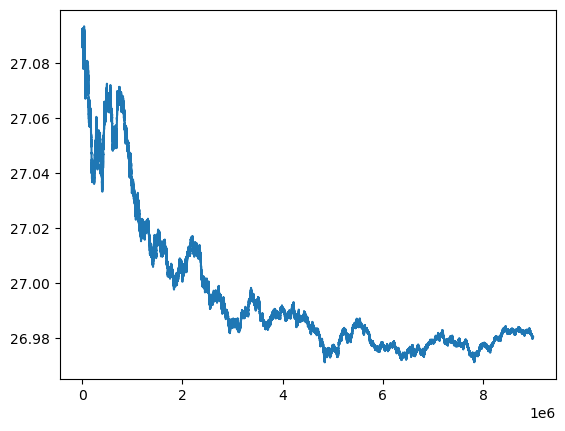

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000970A82B0>

In [144]:
PyPlot.plot(resultTab[3][1000000:nMax])

In [150]:
evalNMax = 200000
gs = gEvaluationTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultTab[1], 26.9; printProgress = true, modCounter = 100000)
println(gs[1])
println("Done")

State Space Completed
Policy Completed
100000
200000
26.745255711213275
Done


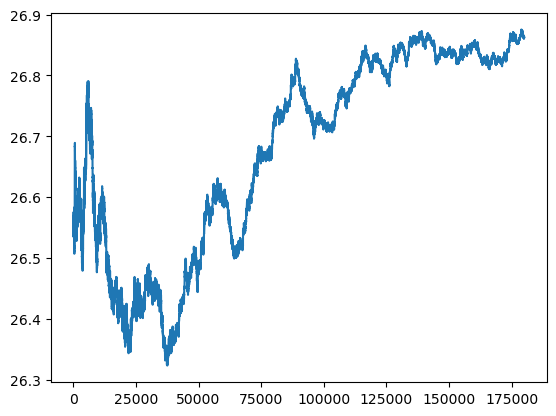

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000097171430>

In [149]:
PyPlot.plot(gs[2][20000:evalNMax])

In [151]:
exactResult = rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.0001; nMax = 0, delScale = 1, printProgress = true, modCounter = 1000)

1000
2000


(26.34578550746539, Dict{Any, Any}([1, 1, 3, 3] => 479.08902878258476, [1, 2, 2, 1] => 503.5744083854171, [3, 1, 3, 2] => 856.9746042899552, [1, 2, 1, 3] => 383.4186099800592, [3, 2, 1, 2] => 793.1478369883854, [2, 3, 3, 3] => 1227.899346077514, [3, 3, 1, 1] => 381.9265330148097, [1, 2, 2, 3] => 697.0842244895607, [3, 2, 2, 2] => 1310.105022707542, [2, 1, 3, 2] => 856.768661701989…), 2887, Dict{Any, Any}([1, 1, 3, 3] => [0, 0, 0, 0], [1, 2, 2, 1] => [0, 0, 0, 0], [3, 1, 3, 2] => [0, 0, 0, 0], [1, 2, 1, 3] => [0, 0, 0, 0], [3, 2, 1, 2] => [0, 0, 0, 0], [2, 3, 3, 3] => [0, 0, 0, 0], [3, 3, 1, 1] => [0, 0, 0, 0], [1, 2, 2, 3] => [0, 0, 0, 0], [3, 2, 2, 2] => [0, 0, 0, 0], [2, 1, 3, 2] => [0, 0, 0, 0]…))

In [153]:
gsExact = gEvaluationTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, exactResult[2], exactResult[1]; printProgress = true, modCounter = 100000)

State Space Completed
Policy Completed
100000
200000


(26.24038177083337, [0.0, 10.0, 10.0, 32.419895890630514, 32.419895890630514, 45.742345962846876, 66.54694000829448, 55.25420437552877, 55.25420437552877, 56.80471987242032  …  26.240934488577615, 26.24137947077575, 26.240443960626305, 26.240443960626305, 26.240568005330353, 26.240466263875376, 26.240466263875376, 26.240493983798586, 26.24038177083337, 26.24038177083337])

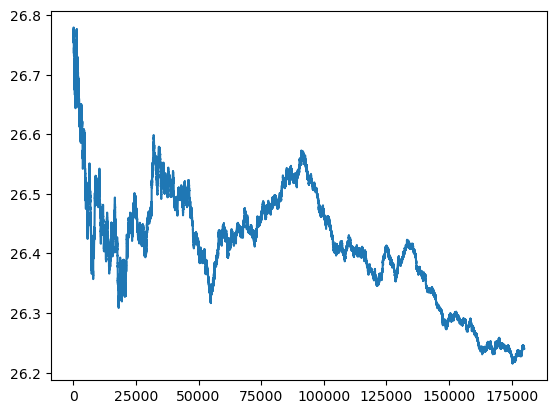

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000972195B0>

In [154]:
PyPlot.plot(gsExact[2][20000:evalNMax])

Seems that non-exploratory SMARVI doesn't find optimal policy.

## Exploratory tabular SMARVI

In [175]:
nMax = 10000000
resultTab = smarviTab_epsGreedy(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, 1.0, 5.0; printProgress = true, modCounter = 1000000)
println("Complete")

1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
Complete


In [176]:
resultTab[2]

27.05946654376713

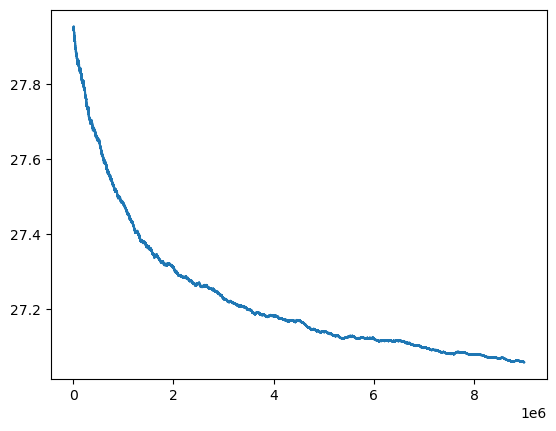

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000AD0ACA90>

In [177]:
PyPlot.plot(resultTab[3][1000000:nMax])

In [186]:
evalNMax = 200000
gs = gEvaluationTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultTab[1], 27.0; printProgress = true, modCounter = 100000)
println(gs[1])
println("Done")

State Space Completed
Policy Completed
100000
200000
26.942673538593727
Done


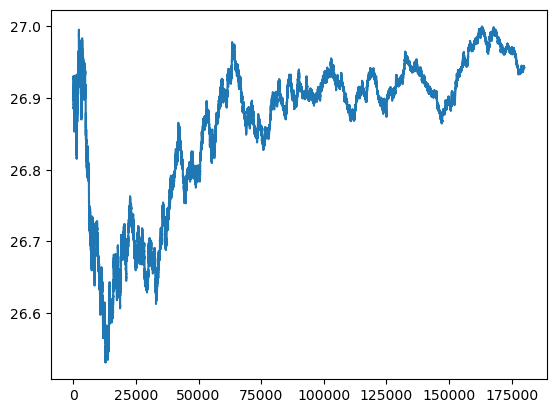

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000B1440EE0>

In [187]:
PyPlot.plot(gs[2][20000:evalNMax])

## Try N = 3 instead 

In [204]:
N = 3
function tau(x)
    return x
end

alpha_d = [0.01*i for i in 1:N]
alpha_r = [0.001*i for i in 1:N] 
beta=10.0
c0=[1.0*i for i in 1:N] 
c1=100.0
r=[100.0*i for i in 1:N]
nMax = 5000000
exactResult = rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.0001; nMax = 0, delScale = 1, printProgress = true, modCounter = 1000)

(26.342216068335787, Dict{Any, Any}([3, 2, 1] => 416.74624542803343, [2, 1, 1] => 148.76956828700858, [3, 1, 3] => 486.0227264623769, [3, 3, 1] => 442.0899981478992, [1, 2, 3] => 519.5629599868041, [1, 3, 3] => 525.5177852558027, [2, 2, 1] => 416.74624542803343, [2, 1, 3] => 474.5473063330596, [1, 1, 2] => 301.5649934644396, [3, 2, 3] => 1072.0238218995871…), 178, Dict{Any, Any}([3, 2, 1] => [0, 0, 0], [2, 1, 1] => [0, 0, 0], [3, 1, 3] => [0, 0, 0], [3, 3, 1] => [0, 0, 0], [1, 2, 3] => [0, 0, 0], [1, 3, 3] => [0, 0, 0], [2, 2, 1] => [0, 0, 0], [2, 1, 3] => [0, 0, 0], [1, 1, 2] => [0, 0, 0], [3, 2, 3] => [0, 0, 0]…))

In [199]:
resultTab = smarviTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, 1.0; printProgress = true, modCounter = 1000000)
println("Complete")

1000000
2000000
3000000
4000000
5000000
Complete


In [200]:
resultTab[2]

26.30859821407018

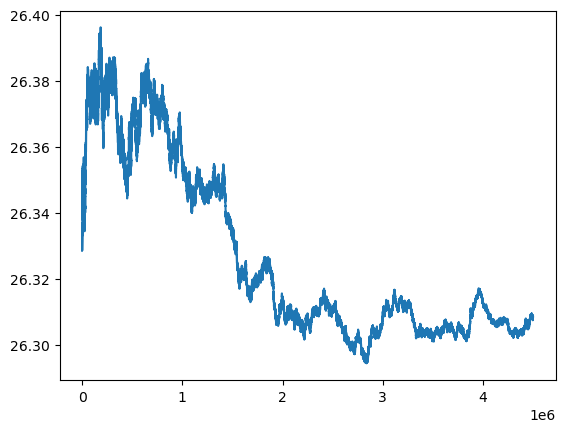

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000008C976A00>

In [202]:
PyPlot.plot(resultTab[3][500000:nMax])

In [205]:
evalNMax = 200000
gs = gEvaluationTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultTab[1], 26.31; printProgress = true, modCounter = 100000)
println(gs[1])
println("Done")

State Space Completed
Policy Completed
100000
200000
26.330273408000576
Done


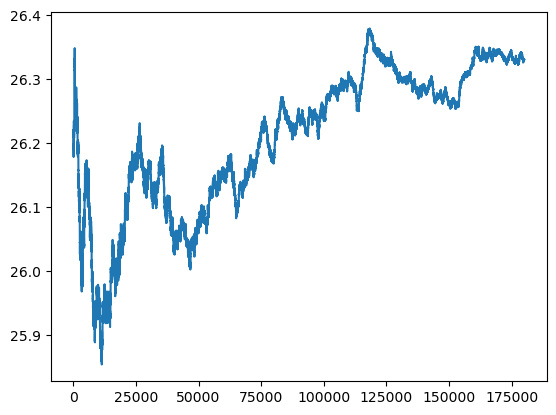

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000B9C04FD0>

In [207]:
PyPlot.plot(gs[2][20000:evalNMax])

Without needing e-greedy action selection, tabular SMARVI finds optimal policy for N = 3 inhomogeneous problem.

## Quick and Dirty test of new VFA

In [83]:
N=5
function tau(x)
    return x
end

alpha_d = [0.01*i for i in 1:N]
alpha_r = [0.001*i for i in 1:N] 
beta=10.0
c0=[1.0*i for i in 1:N] 
c1=100.0
r=[100.0*i for i in 1:N] 

healthUsed = [(s,flows) -> s[i] == 1 && flows[i] > beta/2 for i in 1:N]
healthUnused = [(s,flows) -> s[i] == 1 && flows[i] < beta/2 for i in 1:N]
repairingGood = [(s,flows) -> s[i] == 2 && sum(flows) > beta/2 for i in 1:N]
repairingBad = [(s,flows) -> s[i] == 2 && sum(flows) < beta/2 for i in 1:N]
damagedGood = [(s,flows) -> s[i] == 3 && sum(flows) > beta/2 for i in 1:N]
damagedBad = [(s,flows) -> s[i] == 3 && sum(flows) < beta/2 for i in 1:N]
features = [healthUsed;healthUnused;repairingGood;repairingBad;damagedGood;damagedBad]

vParams = zeros(length(features) + 1)
nMax = 1000000
stepsize = 1/100
resultCont = smarviFlows(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
Complete


Table Complete


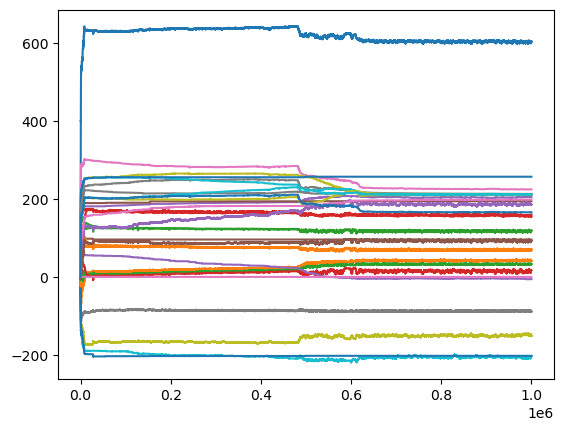

In [87]:
numPar = length(vParams)
paramHist = resultCont[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [76]:
resultCont[1][2]

UndefVarError: UndefVarError: resultCont not defined

In [93]:
evalNMax = 200000
gs = gEvaluation_g0_flows(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultCont[1], features, 26.34; printProgress = true, modCounter = 10000)
gs[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


200001-element Vector{Float64}:
  0.0
 10.0
 10.0
 13.872346313340465
 13.872346313340465
 18.012129500166637
 31.10031781564537
 26.447045491538006
 26.447045491538006
 28.758154310189436
 18.759691620460707
 17.879635126364455
 17.879635126364455
  ⋮
 26.739926692534567
 26.739712560274125
 26.739712560274125
 26.73991413726284
 26.739470967264335
 26.739470967264335
 26.73948344334958
 26.73943855116043
 26.73943855116043
 26.739568402598294
 26.738774773659642
 26.738543391985274

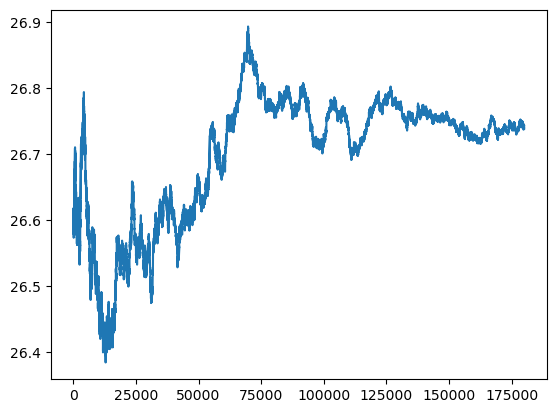

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000D1351550>

In [94]:
PyPlot.plot(gs[1][20000:evalNMax])